In [ ]:
!git clone https://github.com/RiqiangGao/GDP-HMM_AAPMChallenge.git

%pip -q install SimpleITK
%pip -q install monai
%pip -q install easydict

Cloning into 'GDP-HMM_AAPMChallenge'...
remote: Enumerating objects: 620, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 620 (delta 48), reused 60 (delta 36), pack-reused 533 (from 1)
Receiving objects: 100% (620/620), 127.08 MiB | 18.72 MiB/s, done.
Resolving deltas: 100% (220/220), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━

# Load Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict


In [ ]:
import sys
sys.path.append('GDP-HMM_AAPMChallenge')
from toolkit import *

In [ ]:
# data_path = '0617-259694+imrt+MOS_33896.npz'
data_path = '/content/GDP-HMM_AAPMChallenge/data/0617-259694+imrt+MOS_33896.npz'
data_npz = np.load(data_path, allow_pickle=True)
d = EasyDict(data_npz['arr_0'].item())

# Rotate

In [ ]:
import torch
from torchvision.transforms.functional import rotate
from torchvision.transforms import InterpolationMode as intpl

from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes

from torch.nn import Conv2d
from tqdm import tqdm

In [ ]:
# rot_center = d.isocenter[:0:-1] # Last two, reversed order
rot_center = (55.5, 64.5)

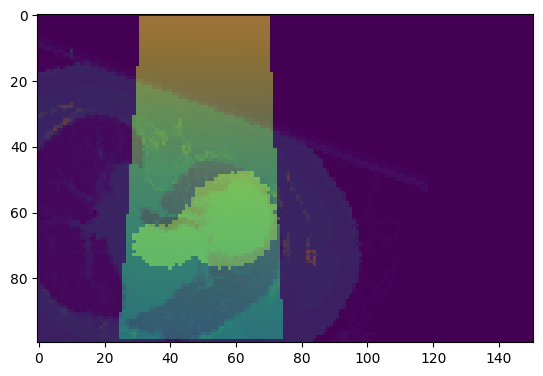

In [ ]:
# The previous beam plate can be generated from 0 degree after rotation

ptv = torch.tensor(d.PTV)
ct = torch.tensor(d.img)

ptv_r = rotate(ptv, 160, center=rot_center)
ct_r = rotate(ct, 160, center=rot_center, fill=-1024) # Notice the CT background is not 0

# Generate the beam plate
beam_plate2_gen = get_per_beamplate(
    PTV_mask = ptv_r.numpy().copy(),
    isocenter = d['isocenter'],
    space = [2, 2.5, 2.5],
    gantry_angle = 0,
    with_distance = True
  ).astype('float')


# plt.imshow(ptv[40], cmap='hot')
plt.imshow(ct_r[40])
plt.imshow(ptv_r[40], alpha=0.5)
plt.imshow(beam_plate2_gen[40], alpha=0.5)

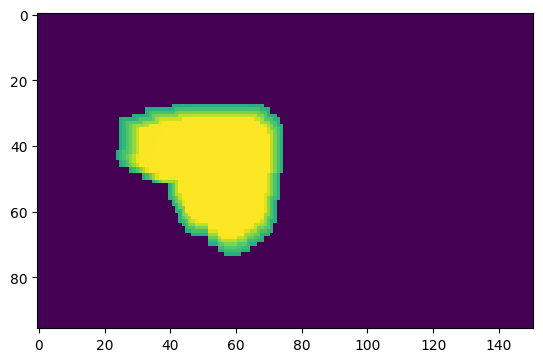

In [ ]:
# BEV
bev = torch.from_numpy(beam_plate2_gen).max(1)[0]
plt.imshow(bev)

In [ ]:
# Get a cylinder subvolume out
# for training the dose model
mask = bev!=0
mask.unsqueeze_(0) # Input needs to be [N, H, W]

x1, y1, x2, y2 = masks_to_boxes(mask)[0].int().tolist()
print(x1, x2, y1, y2)

24 74 28 73


In [ ]:
subvol = beam_plate2_gen[y1:y2, :, x1:x2]

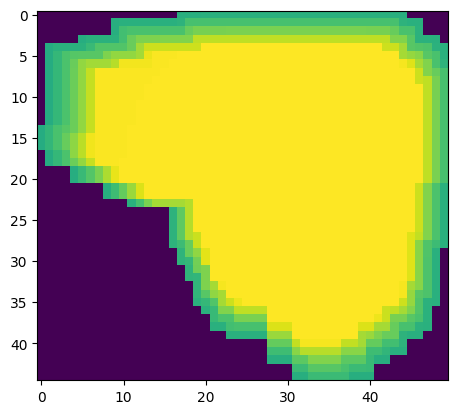

In [ ]:
# BEV
bev_subvol = torch.from_numpy(subvol).max(1)[0]
plt.imshow(bev_subvol)

## Reverse
Put things back

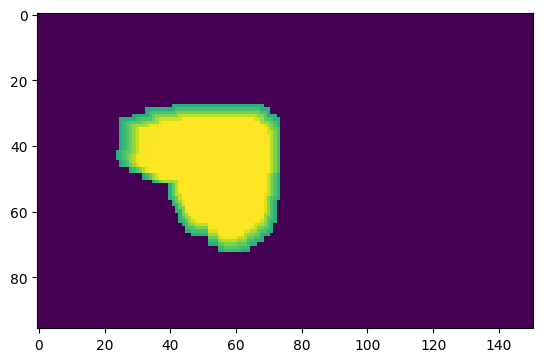

In [ ]:
temp = np.zeros_like(d.img)
temp[y1:y2, :, x1:x2] = subvol

plt.imshow(temp.max(1))

temp = torch.from_numpy(temp)

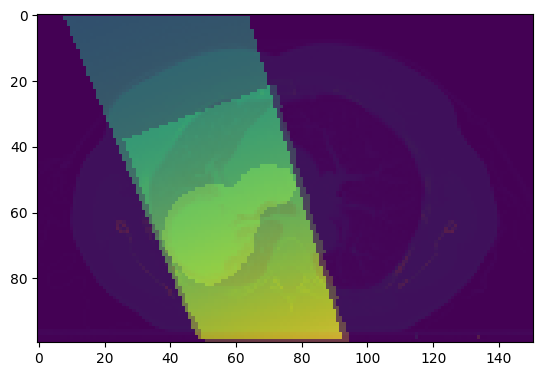

In [ ]:
rot_center = (55.5, 64.5)

temp_r = rotate(temp, -160, center=rot_center)

beam = get_per_beamplate(
    PTV_mask = d.PTV.copy(),
    isocenter = d['isocenter'],
    space = [2, 2.5, 2.5],
    gantry_angle = 160,
    with_distance = True
  ).astype('float')

plt.imshow(d.img[40])
plt.imshow(d.PTV[40], alpha=0.5)
plt.imshow(temp_r[40], alpha=0.5)
plt.imshow(beam[40], alpha=0.5)

# Model

## Get the dose, ct subvolumes

In [ ]:
beam_plate2_gen.shape, d.dose.shape

((96, 100, 151), (96, 100, 151))

In [ ]:
dose = d.dose[y1:y2, :, x1:x2]
ct = d.img[y1:y2, :, x1:x2]

dose = dose.swapaxes(1, 0)
ct = ct.swapaxes(1,0)

dose = torch.from_numpy(dose)
ct = torch.from_numpy(ct)

## Connet to the model

In [ ]:
class Model(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2d(1, 8, 5, padding='same')
    self.conv2 = Conv2d(8, 8, 3, padding='same')
    self.conv3 = Conv2d(8, 1, 3, padding='same')

    self.conv4 = Conv2d(1, 8, 3, padding='same')
    self.conv5 = Conv2d(8, 1, 3, padding='same')

  def forward(self, x, ct):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)

    x2 = self.conv4(ct)
    x2 = self.conv5(x2)

    out = x - x2
    return out

In [ ]:
ct_scale = 1024

dose = d.dose[y1:y2, :, x1:x2] * d.dose_scale
ct = d.img[y1:y2, :, x1:x2] / ct_scale
mask = beam_plate2_gen[y1:y2, :, x1:x2]!=0

dose = dose.swapaxes(1, 0)
ct = ct.swapaxes(1,0)
mask = mask.swapaxes(1,0)

dose = torch.from_numpy(dose).unsqueeze(1).float()
ct = torch.from_numpy(ct).unsqueeze(1).float()
mask = torch.from_numpy(mask).unsqueeze(1)


In [ ]:
dose.shape, ct.shape, mask.shape

(torch.Size([100, 1, 45, 50]),
 torch.Size([100, 1, 45, 50]),
 torch.Size([100, 1, 45, 50]))

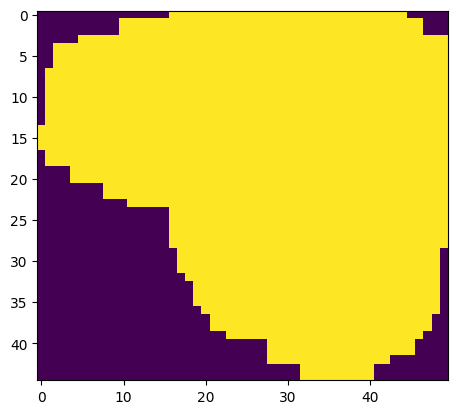

In [ ]:
plt.imshow(mask.max(0)[0].numpy())

In [ ]:
out = torch.ones((1, 45, 50))

model = Model()

output = []
for i in tqdm(range(100)):
  data = torch.concat([out, ct[i]])
  out = model(data)
  output.append(out)
output = torch.stack(output)

100%|██████████| 100/100 [00:00<00:00, 411.44it/s]


## Train on one cube

In [ ]:
epochs = 100
model = Model()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = torch.nn.MSELoss()

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
# The dose and ct are masked by d.Body
body = torch.from_numpy(d.Body[y1:y2, :, x1:x2].swapaxes(1,0)).unsqueeze(1).bool()

In [ ]:
out = mask[1].float()

for epoch in range(epochs):
  pbar = tqdm(range(10), f'Epoch {epoch}')

  for i in pbar:
    opt.zero_grad()

    pred = torch.stack([model(torch.concat([out, ct[j]])) for j in range(100)])

    l = loss(pred[body], dose[body])
    l.backward()
    opt.step()

    pbar.set_postfix_str(f'Loss: {l.item():.3f}')


Epoch 8:  60%|██████    | 6/10 [00:01<00:00,  4.69it/s, Loss: 180.349]


KeyboardInterrupt: 

In [ ]:
dose[body]

tensor([ 3.8923,  4.0604,  4.2983,  ..., 18.1762, 17.2027, 16.1872])

In [ ]:
pred[body]

tensor([12.2439, 12.0628, 12.0392,  ..., 36.8296, 33.7793, 31.5515],
       grad_fn=<IndexBackward0>)

In [ ]:
mask[body].float().mean(), dose[body].mean()

(tensor(0.6526), tensor(35.1123))

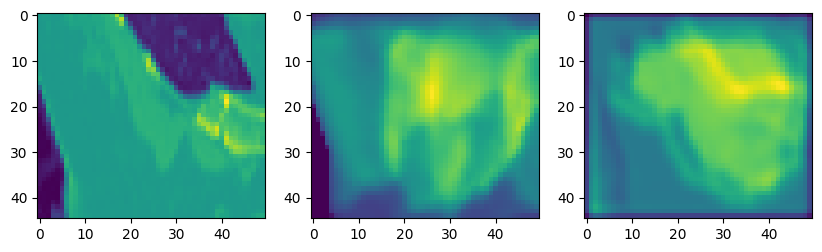

In [ ]:
i = 30
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].imshow(ct[i, 0].detach())
ax[1].imshow(dose[i, 0].detach())
ax[2].imshow(pred[i, 0].detach())

# Class

In [ ]:
from easydict import EasyDict
import torch
from torchvision.transforms.functional import rotate
from toolkit import *
from torchvision.ops import masks_to_boxes
import numpy as np

class Beams():
  def __init__(self, data_dict, ct_scale=1/1024):
    # data_dict: the dictionary from the npy files
    self.d = EasyDict(data_dict)
    self.ct_scale = ct_scale
    self.isocenter = self.d.isocenter
    self.rot_center = [self.isocenter[2]+0.5, self.isocenter[1]+0.5]

    self.body = torch.tensor(self.d.Body).bool()
    self.ptv = torch.tensor(self.d.PTV)
    self.ct = torch.tensor(self.d.img)
    self.dose = torch.tensor(self.d.dose) * self.d.dose_scale

    self.angles = self.d.angle_list.tolist()

    self.bevs = {}
    self.coords = {}
    self.subvols = {}
    self.model_input = {}

    for angle in tqdm(self.angles, 'Getting subvols'):
      self._get_subvol(angle)

    self.model_input = {k: self.get_model_in(v) for k,v in self.subvols.items()}

  def _get_subvol(self, angle):
    # 1. Rotate the images to 0 degree
    ct_r = rotate(self.ct, angle, intpl.BILINEAR, center=self.rot_center)
    dose_r = rotate(self.dose, angle, intpl.BILINEAR, center=self.rot_center)
    ptv_r = rotate(self.ptv, angle, center=self.rot_center)
    body_r = rotate(self.body, angle, center=self.rot_center)

    # 2. Use ptv_r to generate beam_plate (bool)
    #  then use it to crop the images
    beam_plate = get_per_beamplate(
      PTV_mask = ptv_r.numpy().copy(),
      isocenter = self.isocenter,
      space = self.d.spacing[::-1],
      gantry_angle = 0, # this should be 0 after rotation
      with_distance = False
    )
    beam_plate = torch.tensor(beam_plate)

    # For verification - beams eye view, 2D, collapsed from beam_plate
    bev = self.get_bev(beam_plate)

    # Get the bounding box coordinate
    coords = self.get_bounding_coords((bev!=0).unsqueeze(0)) # need (1, ...)
    x1, x2, y1, y2 = coords

    # Sub-volumes, in 0-degree position
    subvol = dict(
        ct = ct_r[y1:y2, :, x1:x2],
        dose = dose_r[y1:y2, :, x1:x2],
        beam_plate = beam_plate[y1:y2, :, x1:x2],
        body = body_r[y1:y2, :, x1:x2],
        ptv = ptv_r[y1:y2, :, x1:x2]
    )

    self.bevs[angle] = bev
    self.coords[angle] = coords
    self.subvols[angle] = subvol

  def get_bev(self, beam_plate):
    # The beam_plate is already rotated
    return beam_plate.max(1)[0]

  def get_bounding_coords(self, mask):
    x1, y1, x2, y2 = masks_to_boxes(mask)[0].int().tolist()
    return (x1, x2, y1, y2)

  def get_model_in(self, subvol):
    # Change the axis order and ndim for the torch model
    dose = subvol['dose']
    ct = subvol['ct'] * self.ct_scale
    beam_plate = subvol['beam_plate']
    body = subvol['body']
    ptv = subvol['ptv']

    return dict(
      dose = dose.swapaxes(1, 0).unsqueeze(1).float(),
      ct = ct.swapaxes(1,0).unsqueeze(1).float(),
      beam_plate = beam_plate.swapaxes(1,0).unsqueeze(1),
      body = body.swapaxes(1,0).unsqueeze(1),
      ptv = ptv.swapaxes(1,0).unsqueeze(1)
    )

  def place_subvol_back(self, subvol, coords, angle):
    # Init a tensor with original array
    arr = torch.zeros_like(self.ct)

    # Put things back to the original size arry, to tensor
    x1, x2, y1, y2 = coords
    arr[y1:y2, :, x1:x2] = subvol

    # Rotate the 0-degree position back to the angle provided
    arr_r = rotate(arr, -angle, interpolation=intpl.BILINEAR, center=self.rot_center)
    return arr_r


In [ ]:
beams = Beams(d)

Getting subvols: 100%|██████████| 9/9 [00:23<00:00,  2.63s/it]


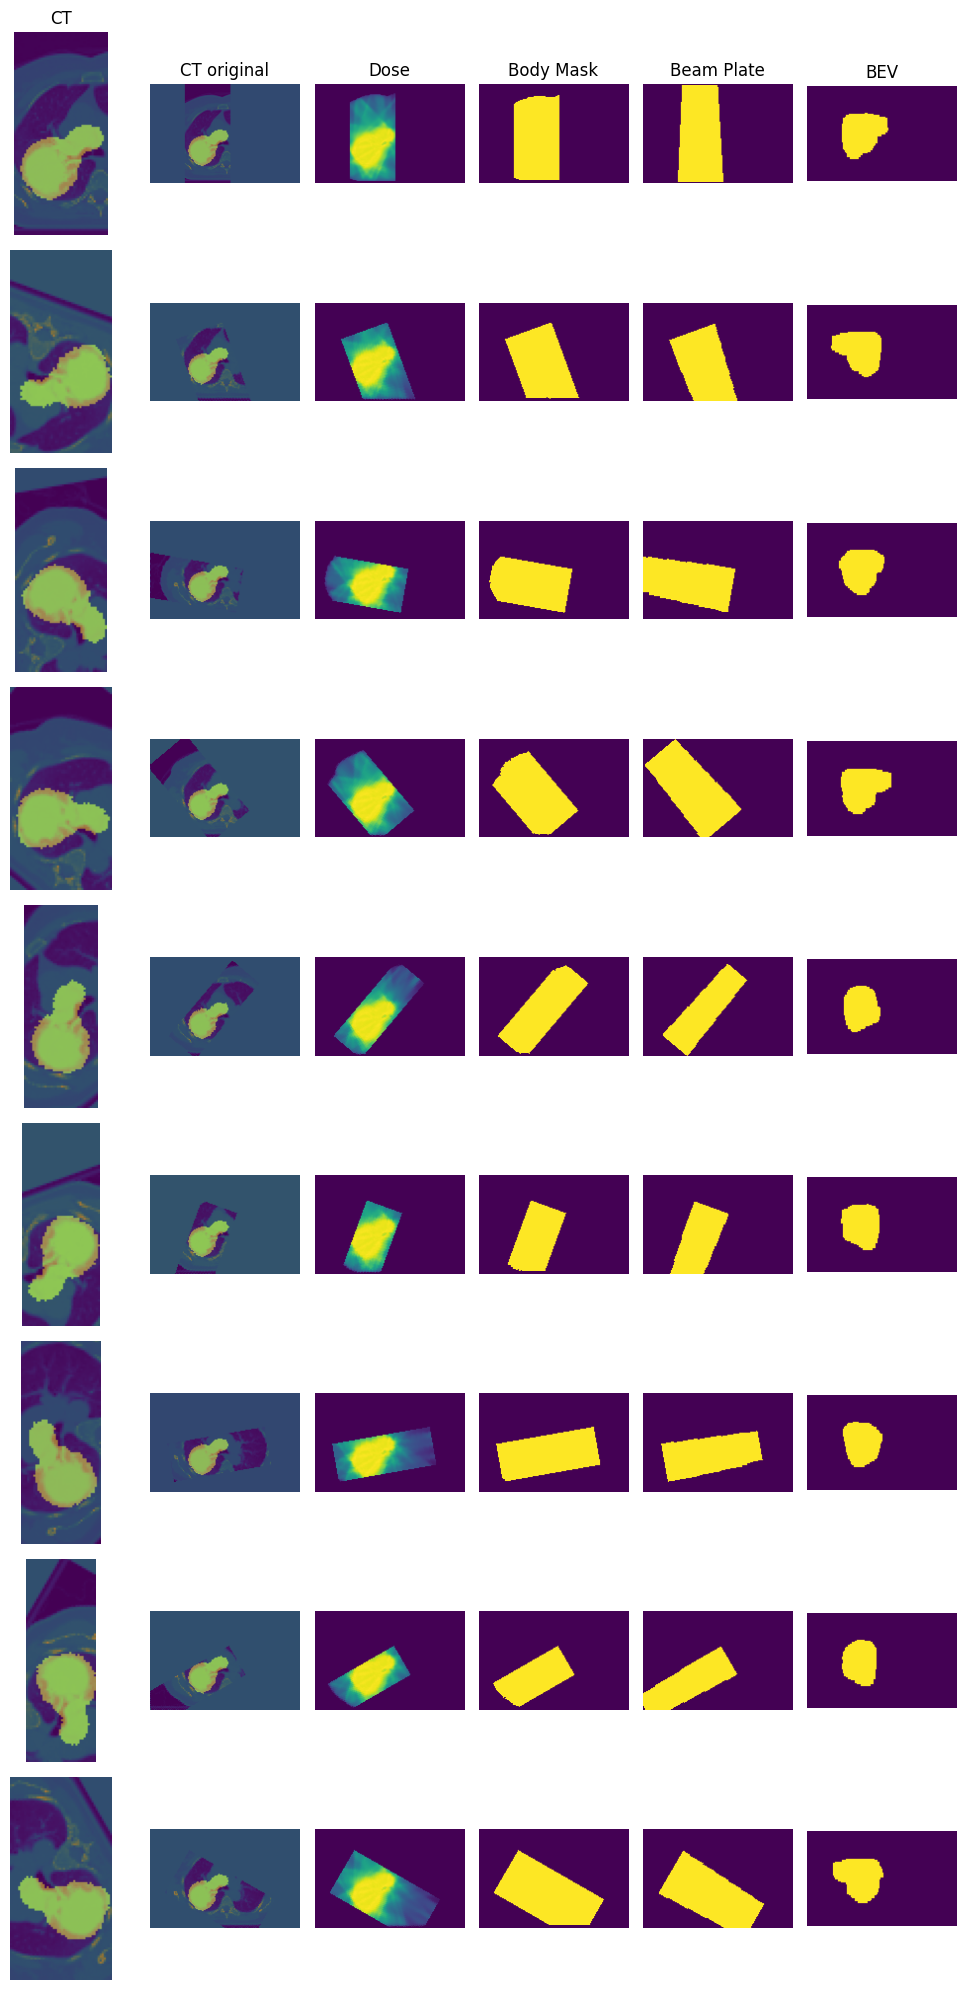

In [ ]:
fig, ax = plt.subplots(9, 6, figsize=(10, 20))

for i, angle in enumerate(beams.angles):
  ct = beams.subvols[angle]['ct']
  dose = beams.subvols[angle]['dose']
  body = beams.subvols[angle]['body']
  beam_plate = beams.subvols[angle]['beam_plate']
  ptv = beams.subvols[angle]['ptv']

  ax[i, 0].imshow(ct[13])
  ax[i, 0].imshow(ptv[13], alpha=0.5)
  ax[i, 1].imshow(beams.place_subvol_back(ct, beams.coords[angle], angle)[40])
  ax[i, 1].imshow(beams.place_subvol_back(ptv, beams.coords[angle], angle)[40], alpha=0.5)
  ax[i, 2].imshow(beams.place_subvol_back(dose, beams.coords[angle], angle)[40], )
  ax[i, 3].imshow(beams.place_subvol_back(body, beams.coords[angle], angle)[40], )
  ax[i, 4].imshow(beams.place_subvol_back(beam_plate, beams.coords[angle], angle)[40], )
  ax[i, 5].imshow(beams.bevs[angle])

ax[0,0].set_title('CT')
ax[0,1].set_title('CT original')
ax[0,2].set_title('Dose')
ax[0,3].set_title('Body Mask')
ax[0,4].set_title('Beam Plate')
ax[0,5].set_title('BEV')

for a in ax.ravel(): a.axis('off')
plt.tight_layout()

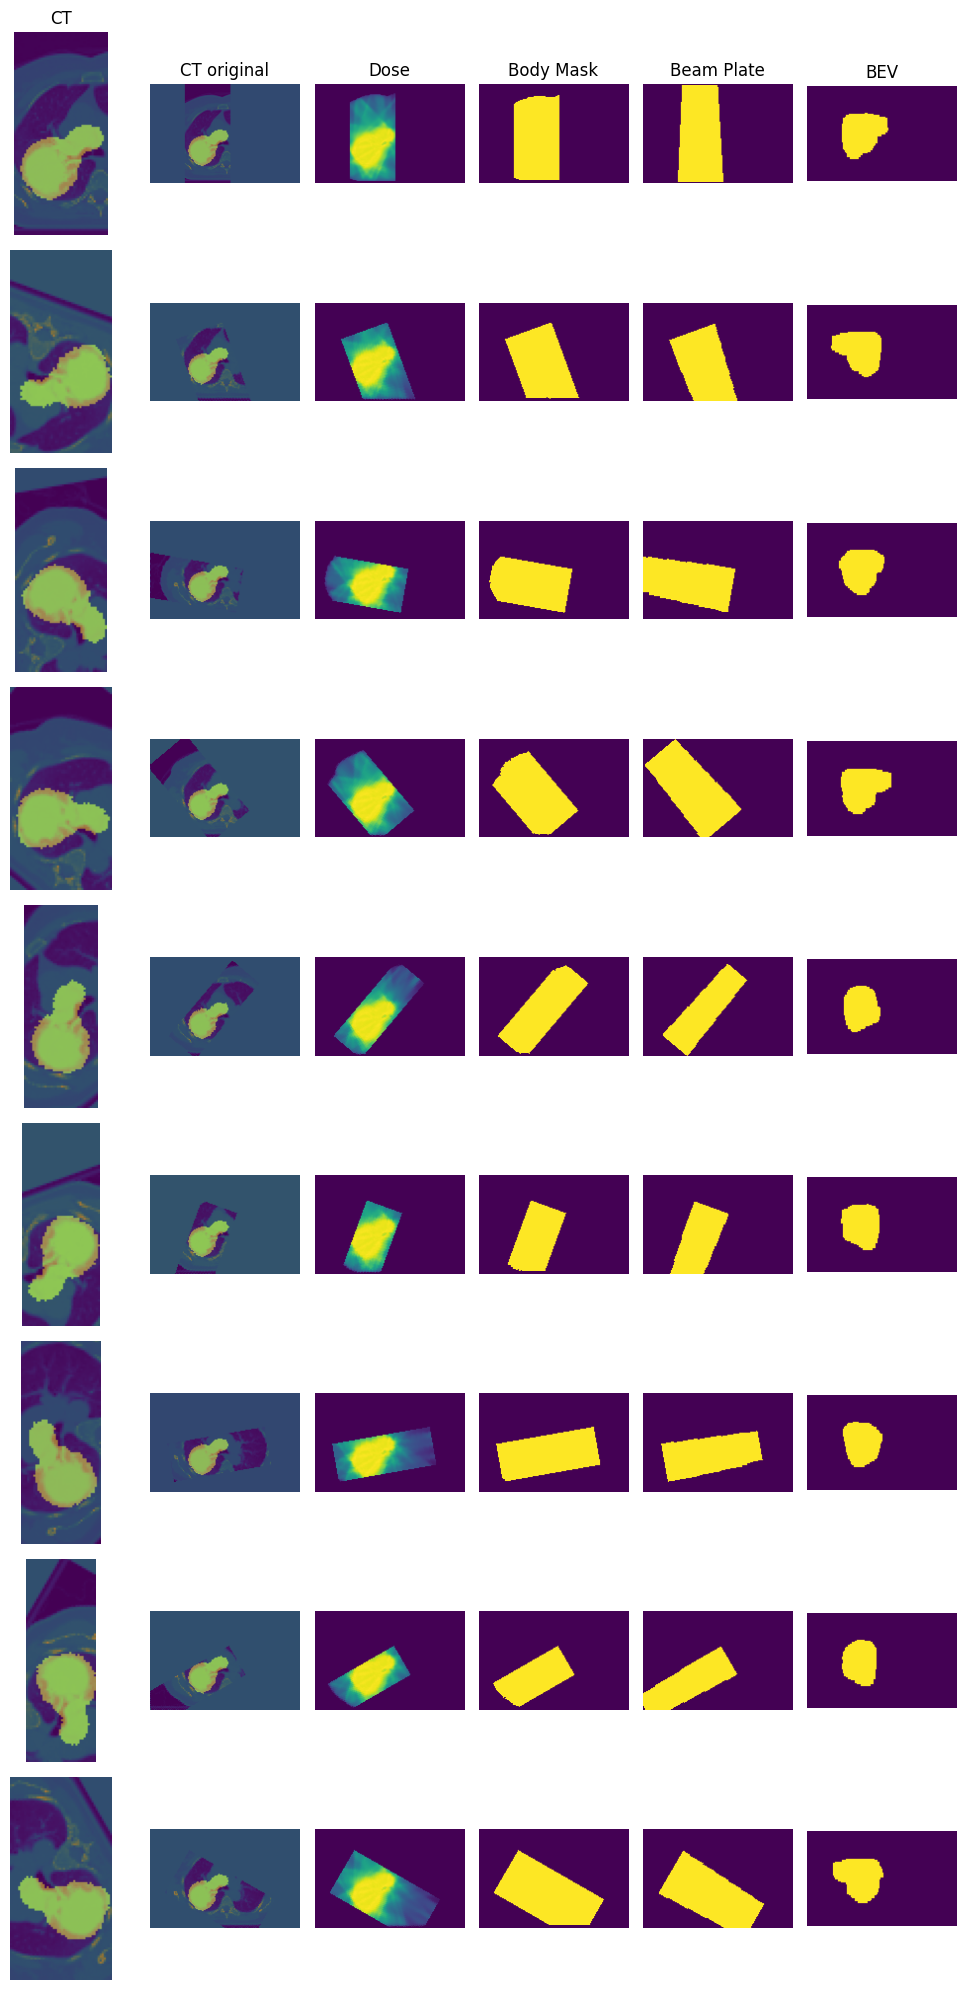

In [ ]:
fig, ax = plt.subplots(9, 6, figsize=(10, 20))

for i, angle in enumerate(beams.angles):
  ct = beams.model_input[angle]['ct'].squeeze().swapaxes(0,1)
  dose = beams.model_input[angle]['dose'].squeeze().swapaxes(0,1)
  body = beams.model_input[angle]['body'].squeeze().swapaxes(0,1)
  beam_plate = beams.model_input[angle]['beam_plate'].squeeze().swapaxes(0,1)
  ptv = beams.model_input[angle]['ptv'].squeeze().swapaxes(0,1)

  ax[i, 0].imshow(ct[13])
  ax[i, 0].imshow(ptv[13], alpha=0.5)
  ax[i, 1].imshow(beams.place_subvol_back(ct, beams.coords[angle], angle)[40])
  ax[i, 1].imshow(beams.place_subvol_back(ptv, beams.coords[angle], angle)[40], alpha=0.5)
  ax[i, 2].imshow(beams.place_subvol_back(dose, beams.coords[angle], angle)[40], )
  ax[i, 3].imshow(beams.place_subvol_back(body, beams.coords[angle], angle)[40], )
  ax[i, 4].imshow(beams.place_subvol_back(beam_plate, beams.coords[angle], angle)[40], )
  ax[i, 5].imshow(beams.bevs[angle])

ax[0,0].set_title('CT')
ax[0,1].set_title('CT original')
ax[0,2].set_title('Dose')
ax[0,3].set_title('Body Mask')
ax[0,4].set_title('Beam Plate')
ax[0,5].set_title('BEV')

for a in ax.ravel(): a.axis('off')
plt.tight_layout()

## Misc. code

In [ ]:
model = Model()

In [ ]:
for angle in tqdm(beams.angles):
  ct = beams.model_input[angle]['ct']
  dose = beams.model_input[angle]['dose']
  beam_plate = beams.model_input[angle]['beam_plate']
  body = beams.model_input[angle]['body']
  ptv = beams.model_input[angle]['ptv']
  break

  0%|          | 0/9 [00:00<?, ?it/s]


In [ ]:
model = Model()
preds_full = []

for angle in tqdm(beams.angles):
  ct = beams.model_input[angle]['ct']
  dose = beams.model_input[angle]['dose']
  beam_plate = beams.model_input[angle]['beam_plate']
  body = beams.model_input[angle]['body']
  ptv = beams.model_input[angle]['ptv']

  pred = []
  out = beam_plate[1]
  for i in range(ct.size(0)):

    out = model(torch.concat([out, ct[i]]))
    out = out.clip(-1e10, 1e10) # Otherwise will explode to nan
    pred.append(out)

  pred = torch.stack(pred)

  pred = pred.squeeze().swapaxes(0,1)

  pred_full = beams.place_subvol_back(pred, beams.coords[angle], angle)

  preds_full.append(pred_full)

y_hat = sum(preds_full)

100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


In [ ]:
y_hat.min(), y_hat.max()

(tensor(-0.9968, dtype=torch.float64, grad_fn=<MinBackward1>),
 tensor(0.2751, dtype=torch.float64, grad_fn=<MaxBackward1>))

## Train

In [ ]:
epochs = 100
model = Model()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = torch.nn.MSELoss()

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-5)


In [ ]:
body_mask = beams.body
ptv_mask = beams.ptv.bool()
dose = beams.dose
print(body_mask.shape)

for epoch in range(1000):
  pbar = tqdm(range(1), f'Epoch {epoch}')

  for _ in pbar:
    opt.zero_grad()

    # Get prediction y_hat
    preds_full = []
    for angle in beams.angles:
      ct = beams.model_input[angle]['ct']
      # dose = beams.model_input[angle]['dose']
      beam_plate = beams.model_input[angle]['beam_plate']
      # body = beams.model_input[angle]['body']
      # ptv = beams.model_input[angle]['ptv']

      pred = []
      # out = beam_plate[1]
      for i in range(ct.size(0)):
        out = model(beam_plate[i].float(), ct[i])
        # out = model(torch.concat([beam_plate[i].float(), beam_plate[i]]))
        # out = out.clip(-1e10, 1e10) # Otherwise will explode to nan
        pred.append(out)

      pred = torch.stack(pred)

      pred = pred.squeeze().swapaxes(0,1)

      pred_full = beams.place_subvol_back(pred, beams.coords[angle], angle)

      preds_full.append(pred_full)

    y_hat = sum(preds_full)

    # l = loss(y_hat[body_mask].float(), dose[body_mask])
    l = loss(y_hat[ptv_mask].float(), dose[ptv_mask])
    l.backward()

    opt.step()

    pbar.set_postfix_str(f'Loss: {l.item():.3f}')


torch.Size([96, 100, 151])


Epoch 34:   0%|          | 0/1 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
y_hat[body_mask].dtype, dose[body_mask].dtype

(torch.float64, torch.float32)

In [ ]:
y_hat[body_mask].max()

tensor(9.0000e+10, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [ ]:
(beams.d.dose * beams.d.dose_scale).max()

63.52158

In [ ]:
beams.d.Body.shape

NameError: name 'beams' is not defined

In [ ]:
y_hat.shape

torch.Size([96, 100, 151])

In [ ]:
pred.detach().shape

torch.Size([44, 100, 50])

In [ ]:
pred.shape, pred_full.shape

(torch.Size([44, 100, 50]), torch.Size([96, 100, 151]))

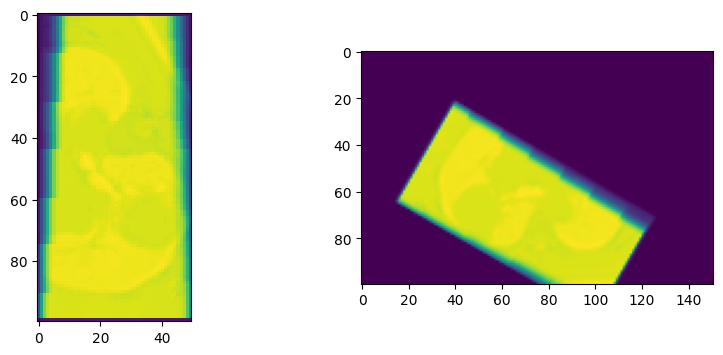

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(pred[10].detach())
ax[1].imshow(pred_full.detach()[40])

In [ ]:
ct.shape

torch.Size([100, 1, 44, 50])

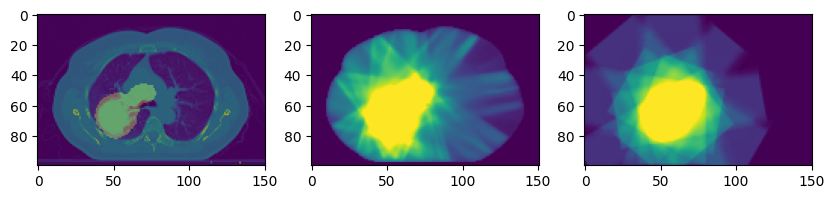

In [ ]:
i = 40
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].imshow(beams.ct[i].detach())
ax[0].imshow(beams.ptv[i], alpha=0.3)
ax[1].imshow(dose[i].detach(), vmin=0, vmax=50)
ax[2].imshow(y_hat[i].detach(), vmin=0, vmax=50)

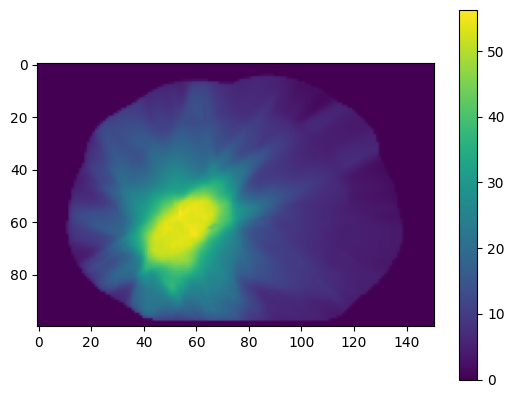

In [ ]:
plt.imshow(dose[30].detach())
plt.colorbar()

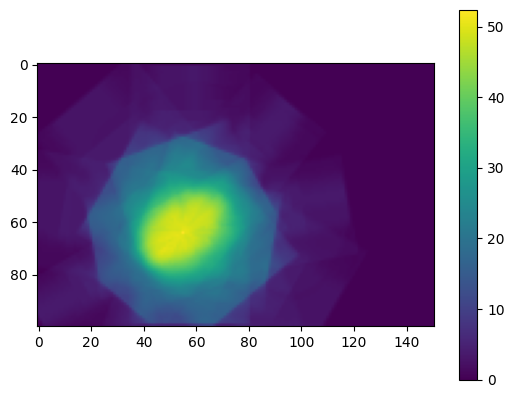

In [ ]:
plt.imshow(y_hat[30].detach())
plt.colorbar()

In [ ]:
loss(y_hat[beams.ptv.bool()], dose[beams.ptv.bool()])

tensor(32.7274, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [ ]:
dose[body_mask]

tensor([0.5149, 0.5132, 0.5142,  ..., 0.5212, 0.5092, 0.4960])

In [ ]:
ref_dose = dose.numpy()
prediction = y_hat.detach().numpy()
data_dict = d

isodose_5Gy_mask = ((ref_dose > 5) | (prediction > 5)) & (data_dict['Body'] > 0)
isodose_ref_5Gy_mask = (ref_dose > 5) & (data_dict['Body'] > 0)
diff = ref_dose - prediction
error = np.sum(np.abs(diff)[isodose_5Gy_mask > 0]) / np.sum(isodose_ref_5Gy_mask)
error

6.209414056051708

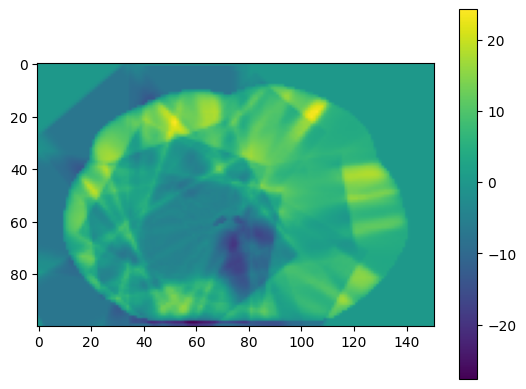

In [ ]:
plt.imshow(diff[40])
plt.colorbar()